### Function to plot an image

In [ ]:
import matplotlib.pyplot as plt

def plot_image(image, title: str = None):
        if title:
            plt.title(title)
        plt.imshow(image)
        plt.show()

### Downloading the zip file with the images

In [ ]:
import requests
from zipfile import ZipFile
from io import BytesIO
import shutil

def download_dataset(save_path):
    r = requests.get("https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/hxt48yk462-1.zip")
    print("Downloading dataset...")
    z = ZipFile(BytesIO(r.content))    
    z.extractall(save_path)
    print("Completed downloading dataset...")

### Extracting the images from the zip file

In [ ]:
import os
import numpy as np
from PIL import Image
from zipfile import ZipFile
from natsort import natsorted


def convert_one_channel(img):
    #some images have 3 channels , although they are grayscale image
    if len(img.shape)>2:
        img=img[:,:,0]
        return img
    else:
        return img
    
def pre_images(path,resize_shape=(512, 512)):
    dirs=natsorted(os.listdir(path))
    sizes=np.zeros([len(dirs),2])
    images_files = [dirs[0]]
    images=img=Image.open(path+dirs[0])
    sizes[0,:]=images.size
    images=(images.resize((resize_shape),Image.ANTIALIAS))
    images=convert_one_channel(np.asarray(images))
    for i in range (1,len(dirs)):
        images_files.append(dirs[i])
        img=Image.open(path+dirs[i])
        sizes[i,:]=img.size
        img=img.resize((resize_shape),Image.ANTIALIAS)
        img=convert_one_channel(np.asarray(img))
        images=np.concatenate((images,img))
    images=np.reshape(images,(len(dirs),resize_shape[0],resize_shape[1],1))
    return images, sizes, images_files

def pre_masks(path, resize_shape=(512,512)):
    dirs=natsorted(os.listdir(path))
    masks=img=Image.open(path+dirs[0])
    masks=(masks.resize((resize_shape),Image.ANTIALIAS))
    masks=convert_one_channel(np.asarray(masks))
    for i in range (1,len(dirs)):
        img=Image.open(path+dirs[i])
        img=img.resize((resize_shape),Image.ANTIALIAS)
        img=convert_one_channel(np.asarray(img))
        masks=np.concatenate((masks,img))
    masks=np.reshape(masks,(len(dirs),resize_shape[0],resize_shape[1],1))
    return masks

## Downloading the dataset and getting the data

In [ ]:
path = "data/"
if not os.path.exists(path +'/DentalPanoramicXrays.zip'):
    if not os.path.exists(path):
        os.mkdir(path)
    download_dataset(path)
ZipFile(path + "/DentalPanoramicXrays.zip").extractall(path)

In [ ]:
X, X_sizes, image_names = pre_images(path + 'Images/')

## Plotting some images

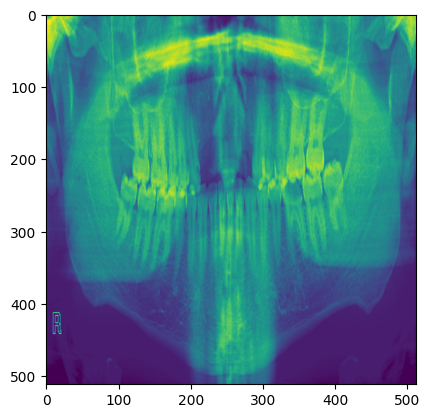

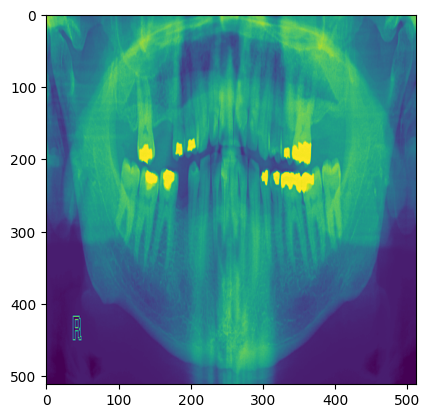

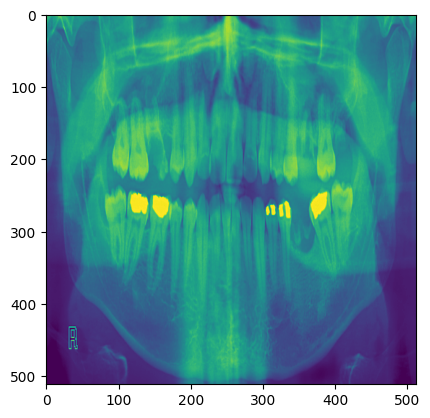

In [ ]:
import random

for _ in range(3):
    plot_image(X[random.randint(0, len(X))])

## Downloading the repository for the pretrained model

In [ ]:
!git clone https://github.com/NathanUA/U-2-Net.git

Cloning into 'U-2-Net'...
remote: Enumerating objects: 1074, done.
remote: Counting objects: 100% (1074/1074), done.
remote: Compressing objects: 100% (550/550), done.
remote: Total 1074 (delta 535), reused 1040 (delta 520), pack-reused 0
Receiving objects: 100% (1074/1074), 66.94 MiB | 17.14 MiB/s, done.
Resolving deltas: 100% (535/535), done.


## Function to download the model

In [ ]:
def download_model(save_path):
    link = "https://drive.google.com/u/0/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ&export=download&confirm=t&uuid=456622f2-17f7-4428-8b64-2016ea27f03e&at=AKKF8vyxny56XsE_CMb8As2EL5NJ:1685724670825"
    print("Downloading model...")
    response = requests.get(link, stream=True)
    with open(save_path + '/u2net.pth', 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)
    print("Completed downloading model...")

## Downloading the model

In [ ]:
path = "U-2-Net/saved_models/u2net"
if not os.path.exists(path +'/u2net.pth'):
    if not os.path.exists(path):
      os.mkdir(path)
    download_model(path + '/')

Completed downloading model...


## Entering the folder with the pretrained model

In [ ]:
%cd U-2-Net

/content/U-2-Net


## Code for applying the trained model for our dataset

In [ ]:
import os
from skimage import io, transform
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms#, utils
# import torch.optim as optim

import numpy as np
from PIL import Image
import glob

from data_loader import RescaleT
from data_loader import ToTensor
from data_loader import ToTensorLab
from data_loader import SalObjDataset

from model import U2NET # full size version 173.6 MB
from model import U2NETP # small version u2net 4.7 MB

# normalize the predicted SOD probability map
def normPRED(d):
    ma = torch.max(d)
    mi = torch.min(d)

    dn = (d-mi)/(ma-mi)

    return dn

def save_output(image_name,pred,d_dir):

    predict = pred
    predict = predict.squeeze()
    predict_np = predict.cpu().data.numpy()

    im = Image.fromarray(predict_np*255).convert('RGB')
    img_name = image_name.split(os.sep)[-1]
    image = io.imread(image_name)
    imo = im.resize((image.shape[1],image.shape[0]),resample=Image.BILINEAR)

    pb_np = np.array(imo)

    aaa = img_name.split(".")
    bbb = aaa[0:-1]
    imidx = bbb[0]
    for i in range(1,len(bbb)):
        imidx = imidx + "." + bbb[i]

    imo.save(d_dir+imidx+'.png')

def apply_u2net(image_folder, results_folder):

    # --------- 1. get image path and name ---------
    model_name='u2net'#u2netp



    image_dir = os.path.join(os.getcwd(), image_folder)
    prediction_dir = os.path.join(os.getcwd(), results_folder + os.sep)
    model_dir = os.path.join(os.getcwd(), 'saved_models', model_name, model_name + '.pth')

    img_name_list = glob.glob(image_dir + os.sep + '*')
    print(img_name_list)

    # --------- 2. dataloader ---------
    #1. dataloader
    test_salobj_dataset = SalObjDataset(img_name_list = img_name_list,
                                        lbl_name_list = [],
                                        transform=transforms.Compose([RescaleT(320),
                                                                      ToTensorLab(flag=0)])
                                        )
    test_salobj_dataloader = DataLoader(test_salobj_dataset,
                                        batch_size=1,
                                        shuffle=False,
                                        num_workers=1)

    # --------- 3. model define ---------
    if(model_name=='u2net'):
        print("...load U2NET---173.6 MB")
        net = U2NET(3,1)
    elif(model_name=='u2netp'):
        print("...load U2NEP---4.7 MB")
        net = U2NETP(3,1)

    if torch.cuda.is_available():
        net.load_state_dict(torch.load(model_dir))
        net.cuda()
    else:
        net.load_state_dict(torch.load(model_dir, map_location='cpu'))
    net.eval()

    # --------- 4. inference for each image ---------
    for i_test, data_test in enumerate(test_salobj_dataloader):

        print("inferencing:",img_name_list[i_test].split(os.sep)[-1])

        inputs_test = data_test['image']
        inputs_test = inputs_test.type(torch.FloatTensor)

        if torch.cuda.is_available():
            inputs_test = Variable(inputs_test.cuda())
        else:
            inputs_test = Variable(inputs_test)

        d1,d2,d3,d4,d5,d6,d7= net(inputs_test)

        # normalization
        pred = d1[:,0,:,:]
        pred = normPRED(pred)

        # save results to test_results folder
        if not os.path.exists(prediction_dir):
            os.makedirs(prediction_dir, exist_ok=True)
        save_output(img_name_list[i_test],pred,prediction_dir)

        del d1,d2,d3,d4,d5,d6,d7


## Running the model and returning to the folder with the project, generating the masks

In [ ]:
apply_u2net('../data/Images', '../model_results')
%cd ..

['/content/U-2-Net/../data/Images/111.png', '/content/U-2-Net/../data/Images/42.png', '/content/U-2-Net/../data/Images/35.png', '/content/U-2-Net/../data/Images/43.png', '/content/U-2-Net/../data/Images/92.png', '/content/U-2-Net/../data/Images/55.png', '/content/U-2-Net/../data/Images/11.png', '/content/U-2-Net/../data/Images/10.png', '/content/U-2-Net/../data/Images/107.png', '/content/U-2-Net/../data/Images/73.png', '/content/U-2-Net/../data/Images/38.png', '/content/U-2-Net/../data/Images/98.png', '/content/U-2-Net/../data/Images/59.png', '/content/U-2-Net/../data/Images/23.png', '/content/U-2-Net/../data/Images/77.png', '/content/U-2-Net/../data/Images/96.png', '/content/U-2-Net/../data/Images/5.png', '/content/U-2-Net/../data/Images/61.png', '/content/U-2-Net/../data/Images/53.png', '/content/U-2-Net/../data/Images/66.png', '/content/U-2-Net/../data/Images/91.png', '/content/U-2-Net/../data/Images/15.png', '/content/U-2-Net/../data/Images/51.png', '/content/U-2-Net/../data/Images

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


inferencing: 42.png
inferencing: 35.png
inferencing: 43.png
inferencing: 92.png
inferencing: 55.png
inferencing: 11.png
inferencing: 10.png
inferencing: 107.png
inferencing: 73.png
inferencing: 38.png
inferencing: 98.png
inferencing: 59.png
inferencing: 23.png
inferencing: 77.png
inferencing: 96.png
inferencing: 5.png
inferencing: 61.png
inferencing: 53.png
inferencing: 66.png
inferencing: 91.png
inferencing: 15.png
inferencing: 51.png
inferencing: 57.png
inferencing: 62.png
inferencing: 50.png
inferencing: 68.png
inferencing: 32.png
inferencing: 103.png
inferencing: 105.png
inferencing: 18.png
inferencing: 4.png
inferencing: 24.png
inferencing: 90.png
inferencing: 36.png
inferencing: 28.png
inferencing: 6.png
inferencing: 60.png
inferencing: 106.png
inferencing: 95.png
inferencing: 58.png
inferencing: 12.png
inferencing: 46.png
inferencing: 1.png
inferencing: 44.png
inferencing: 109.png
inferencing: 52.png
inferencing: 26.png
inferencing: 82.png
inferencing: 31.png
inferencing: 49.png

## Applying the generated masks on our images

In [ ]:
import cv2


masks = pre_masks('model_results/')
images_with_mask = [cv2.bitwise_and(image, mask) for image, mask in zip(X, masks)]

## Showing some examples of the resulted segmentation

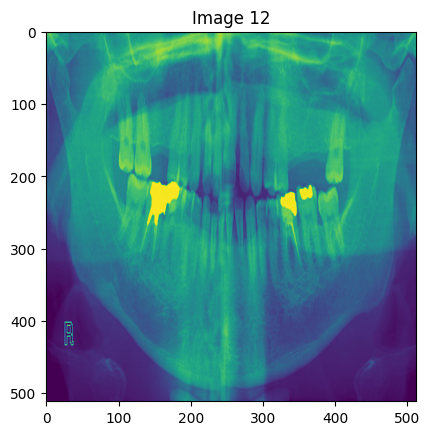

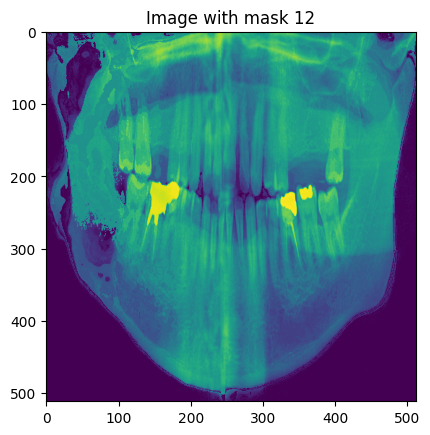

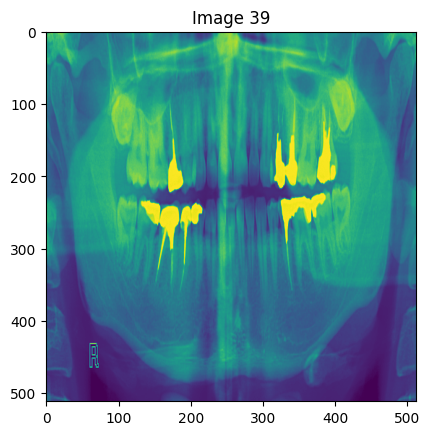

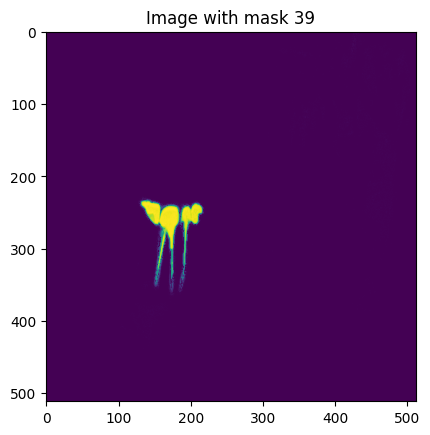

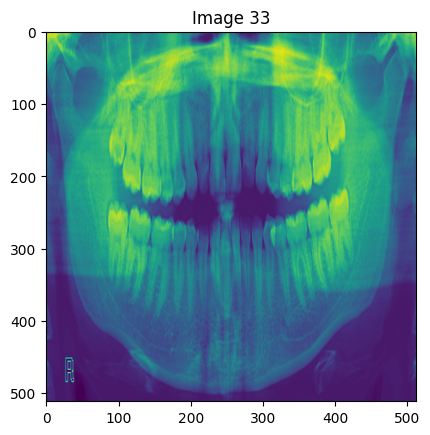

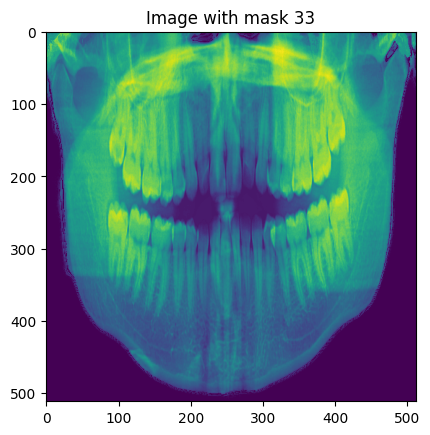

In [ ]:
for _ in range(3):
    random_idx = random.randint(0, len(X))
    plot_image(X[random_idx], title=f'Image {random_idx}')
    plot_image(images_with_mask[random_idx], title=f'Image with mask {random_idx}')

## Saving the results

In [ ]:
print(image_names)
if not os.path.exists('masked_images'):
    os.mkdir('masked_images')
for image_arr, image_name in zip(images_with_mask, image_names):
        cv2.imwrite('masked_images/' + image_name, image_arr)

['1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png', '10.png', '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png', '40.png', '41.png', '42.png', '43.png', '44.png', '45.png', '46.png', '47.png', '48.png', '49.png', '50.png', '51.png', '52.png', '53.png', '54.png', '55.png', '56.png', '57.png', '58.png', '59.png', '60.png', '61.png', '62.png', '63.png', '64.png', '65.png', '66.png', '67.png', '68.png', '69.png', '70.png', '71.png', '72.png', '73.png', '74.png', '75.png', '76.png', '77.png', '78.png', '79.png', '80.png', '81.png', '82.png', '83.png', '84.png', '85.png', '86.png', '87.png', '88.png', '89.png', '90.png', '91.png', '92.png', '93.png', '94.png', '95.png', '96.png', '97.png', '98.png', '99.png', '100.png', '101.pn

## Applying the model again to see if there are better results, but we couldn't see improvements

In [ ]:
%cd U-2-Net
apply_u2net('../masked_images', '../model_results2')
%cd ..

/content/U-2-Net
['/content/U-2-Net/../masked_images/6.png', '/content/U-2-Net/../masked_images/56.png', '/content/U-2-Net/../masked_images/45.png', '/content/U-2-Net/../masked_images/95.png', '/content/U-2-Net/../masked_images/43.png', '/content/U-2-Net/../masked_images/37.png', '/content/U-2-Net/../masked_images/78.png', '/content/U-2-Net/../masked_images/26.png', '/content/U-2-Net/../masked_images/38.png', '/content/U-2-Net/../masked_images/80.png', '/content/U-2-Net/../masked_images/101.png', '/content/U-2-Net/../masked_images/108.png', '/content/U-2-Net/../masked_images/7.png', '/content/U-2-Net/../masked_images/21.png', '/content/U-2-Net/../masked_images/86.png', '/content/U-2-Net/../masked_images/58.png', '/content/U-2-Net/../masked_images/63.png', '/content/U-2-Net/../masked_images/35.png', '/content/U-2-Net/../masked_images/105.png', '/content/U-2-Net/../masked_images/44.png', '/content/U-2-Net/../masked_images/1.png', '/content/U-2-Net/../masked_images/90.png', '/content/U-2-

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


inferencing: 45.png
inferencing: 95.png
inferencing: 43.png
inferencing: 37.png
inferencing: 78.png
inferencing: 26.png
inferencing: 38.png
inferencing: 80.png
inferencing: 101.png
inferencing: 108.png
inferencing: 7.png
inferencing: 21.png
inferencing: 86.png
inferencing: 58.png
inferencing: 63.png
inferencing: 35.png
inferencing: 105.png
inferencing: 44.png
inferencing: 1.png
inferencing: 90.png
inferencing: 97.png
inferencing: 112.png
inferencing: 16.png
inferencing: 17.png
inferencing: 51.png
inferencing: 102.png
inferencing: 93.png
inferencing: 50.png
inferencing: 99.png
inferencing: 13.png
inferencing: 29.png
inferencing: 92.png
inferencing: 71.png
inferencing: 84.png
inferencing: 15.png
inferencing: 81.png
inferencing: 96.png
inferencing: 60.png
inferencing: 54.png
inferencing: 48.png
inferencing: 116.png
inferencing: 53.png
inferencing: 49.png
inferencing: 28.png
inferencing: 87.png
inferencing: 67.png
inferencing: 4.png
inferencing: 106.png
inferencing: 27.png
inferencing: 88.

In [ ]:
masks2 = pre_masks('model_results2/')
images_with_mask2 = [cv2.bitwise_and(image, mask) for image, mask in zip(images_with_mask, masks2)]

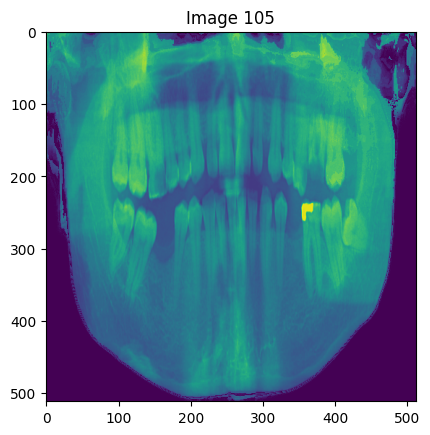

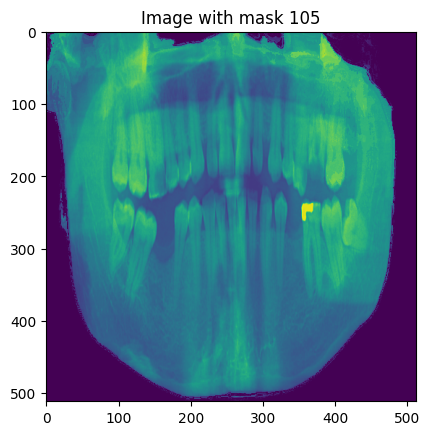

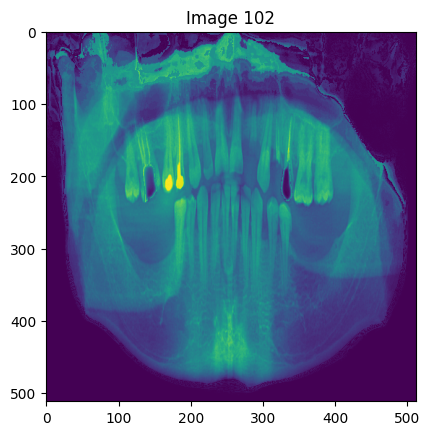

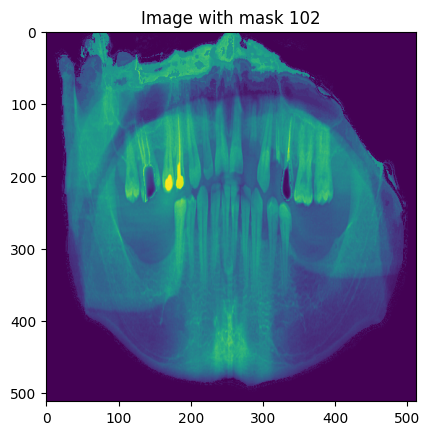

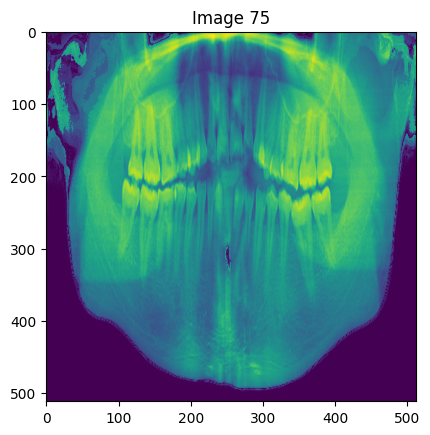

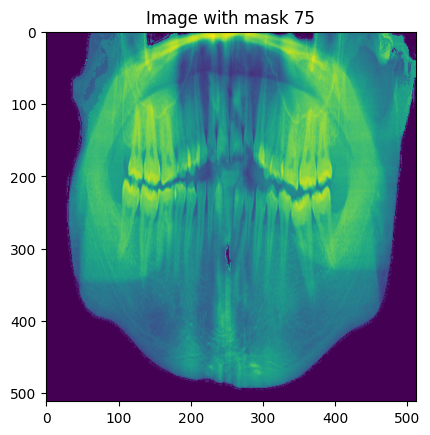

In [ ]:
import cv2

for _ in range(3):
    random_idx = random.randint(0, len(images_with_mask))
    plot_image(images_with_mask[random_idx], title=f'Image {random_idx}')
    plot_image(images_with_mask2[random_idx], title=f'Image with mask {random_idx}')